In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pickle
from xgboost import XGBClassifier
import shap

# Reading Data and droping the unnamed column

In [17]:
df = pd.read_csv("cs-training.csv", usecols= lambda col:col not in["Unnamed: 0"])
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Separating variables from dataframe

In [18]:
training_variable =['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

objective_variable = ['SeriousDlqin2yrs']

# Dropping Dupicates

In [19]:
df["duplicates"] = df.duplicated()

df.duplicates.value_counts()

False    149391
True        609
Name: duplicates, dtype: int64

In [20]:
df = df.drop_duplicates()

df=df.drop(columns="duplicates")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Substituting 98 and 96 with median

In [53]:
median_90 = df.NumberOfTimes90DaysLate.median()
median_30 = df["NumberOfTime30-59DaysPastDueNotWorse"].median()
median_60 = df["NumberOfTime60-89DaysPastDueNotWorse"].median()
print(median_30,median_90,median_60)

0.0 0.0 0.0


In [54]:
df["NumberOfTime30-59DaysPastDueNotWorse"]= df["NumberOfTime30-59DaysPastDueNotWorse"].replace(98,median_30)
df["NumberOfTime60-89DaysPastDueNotWorse"] = df["NumberOfTime60-89DaysPastDueNotWorse"].replace(98,median_60)
df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].replace(98,median_90)
df["NumberOfTime30-59DaysPastDueNotWorse"]= df["NumberOfTime30-59DaysPastDueNotWorse"].replace(96,median_30)
df["NumberOfTime60-89DaysPastDueNotWorse"] = df["NumberOfTime60-89DaysPastDueNotWorse"].replace(96,median_60)
df["NumberOfTimes90DaysLate"] = df["NumberOfTimes90DaysLate"].replace(96,median_90)
df["age"]= df["age"].replace(0,df["age"].median())

# Substituting NaNs with median in dependants

In [23]:
df["NumberOfDependents"] =df["NumberOfDependents"].fillna(round(df["NumberOfDependents"].median()))

## Using a linear regresion in order tu fill NaNs of Monthly income

In [24]:
train = df[df.MonthlyIncome.isnull() == False]
test = df[df.MonthlyIncome.isnull() == True]


In [25]:
X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train.MonthlyIncome
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
lmMod = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

In [28]:
pred = lmMod.predict(X_test)
pred

array([2565.02351156, 3203.7116041 , 6172.47595393, ..., 5509.70997141,
       4035.97469594, 3223.36989092])

In [29]:
predNoZero = []
for val in pred:
    if val >= 0:
        predNoZero.append(val)
    else:
        predNoZero.append(0.)

In [30]:
testFull = df[df.MonthlyIncome.isnull() == True]

In [31]:
testFull["MonthlyIncome"] = predNoZero

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
monNew = []
for index in df.index:
    if df.MonthlyIncome[index].is_integer() == True:
        monNew.append(df.MonthlyIncome[index])
    else:
        monNew.append(testFull.MonthlyIncome[index])

In [33]:
df.MonthlyIncome = monNew

## ML clasification model start here

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = df[variables_entrenamiento]
y = df[variable_objetivo]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size =0.5)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(104819, 10) (104819, 1)
(52410, 10) (52410, 1)
(52409, 10) (52409, 1)


In [37]:
clfArr = []
yscoresArr = []

roc_auc_scoreDict = {}
#test array is 
#arr = [1,2,3]
#final test array is 
tree_num = [1,10,25,50,75,100,125,150,200,300]
var_num = [1,3,10]
#arr = [1,10,25,50, 75, 100]
ind = 0
for t in tree_num:
#    print(t)
    roc_auc_scoreDict[t] = {}
    for v in var_num:
        print("%d, %d" % (t, v))
        clf = RandomForestClassifier(n_estimators=t
                                     , n_jobs=-1, verbose=1, max_features=v)
        clf.fit(X_train,y_train)
        y_pred = clf.predict_proba(X_val[:])[:, 1]
        roc_auc_scoreDict[t][v] = roc_auc_score(y_val, y_pred)
print(roc_auc_scoreDict)

1, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


1, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


1, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


10, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


10, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


10, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


25, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


25, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


25, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


50, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


50, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


50, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


75, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.4s finished


75, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.3s finished


75, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.3s finished


100, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


100, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


100, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


125, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


125, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.6s finished


125, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   32.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished


150, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


150, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


150, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.8s finished


200, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


200, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished


200, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished


300, 1


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.6s finished


300, 3


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.5s finished


300, 10


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.4s finished


{1: {1: 0.850421734327249, 3: 0.8576896556574901, 10: 0.8578019104662882}, 10: {1: 0.9995993143333897, 3: 0.999634617905004, 10: 0.999588043474411}, 25: {1: 0.9999757639699085, 3: 0.9999617055991404, 10: 0.999947611868815}, 50: {1: 0.9999859946685684, 3: 0.9999897516215612, 10: 0.9999822789683928}, 75: {1: 0.999994168619629, 3: 0.9999943336308977, 10: 0.9999881103487636}, 100: {1: 0.999992094192251, 3: 0.999991056978562, 10: 0.9999861302135392}, 125: {1: 0.9999958717716525, 3: 0.999994345417417, 10: 0.9999908625009952}, 150: {1: 0.9999953944176251, 3: 0.9999915637988874, 10: 0.9999935910801886}, 200: {1: 0.9999945104286856, 3: 0.9999943984567533, 10: 0.9999875622756211}, 300: {1: 0.9999948286647039, 3: 0.9999921118720299, 10: 0.9999919940068378}}


# Hyperparameter tuning

In [38]:
from pprint import pprint
pprint(roc_auc_scoreDict)

{1: {1: 0.850421734327249, 3: 0.8576896556574901, 10: 0.8578019104662882},
 10: {1: 0.9995993143333897, 3: 0.999634617905004, 10: 0.999588043474411},
 25: {1: 0.9999757639699085, 3: 0.9999617055991404, 10: 0.999947611868815},
 50: {1: 0.9999859946685684, 3: 0.9999897516215612, 10: 0.9999822789683928},
 75: {1: 0.999994168619629, 3: 0.9999943336308977, 10: 0.9999881103487636},
 100: {1: 0.999992094192251, 3: 0.999991056978562, 10: 0.9999861302135392},
 125: {1: 0.9999958717716525, 3: 0.999994345417417, 10: 0.9999908625009952},
 150: {1: 0.9999953944176251, 3: 0.9999915637988874, 10: 0.9999935910801886},
 200: {1: 0.9999945104286856, 3: 0.9999943984567533, 10: 0.9999875622756211},
 300: {1: 0.9999948286647039, 3: 0.9999921118720299, 10: 0.9999919940068378}}


In [39]:
dfauc = pd.DataFrame(roc_auc_scoreDict)
dfauc

,1,10,25,50,75,100,125,150,200,300
1,0.850422,0.999599,0.999976,0.999986,0.999994,0.999992,0.999996,0.999995,0.999995,0.999995
3,0.857690,0.999635,0.999962,0.999990,0.999994,0.999991,0.999994,0.999992,0.999994,0.999992
10,0.857802,0.999588,0.999948,0.999982,0.999988,0.999986,0.999991,0.999994,0.999988,0.999992


Text(0.5, 1.0, 'Random Forest Performance')

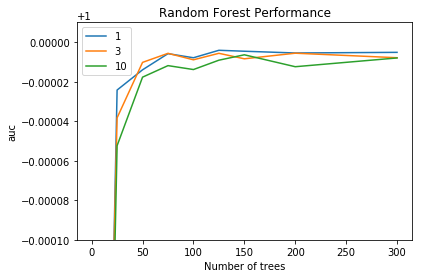

In [40]:
for v in var_num:
    plt.plot(tree_num, dfauc.loc[v], label=v )
plt.ylim([.9999,1.00001])
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("auc")
plt.title("Random Forest Performance")

## Best clasification model is with 150 Tres and 1 feature(based over prediction on validation set)

In [42]:
best_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, verbose=1, max_features=1)
best_clf.fit(X_train,y_train)

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

## Saving model in binary file using Pickle

In [43]:
with open ('rft.p', 'wb') as f:
    pickle.dump(best_clf, f)
    

In [44]:
with open('rft.p', 'rb') as f:
    model = pickle.load(f)

## Testing

In [45]:
New_client = X_test.reset_index(drop=True).loc[[2456]]
print(New_client)

      RevolvingUtilizationOfUnsecuredLines  age  \
2456                              0.003251   76   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
2456                                     0   0.103112         2666.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
2456                                7                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
2456                             0                                     0   

      NumberOfDependents  
2456                 0.0  


In [47]:
model.predict_proba(New_client)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


array([[1., 0.]])

In [50]:
ypred_test = model.predict(X_test)
ypred_test

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Score

In [52]:
score = roc_auc_score(y_test, ypred_test)
score

0.9976684839224583

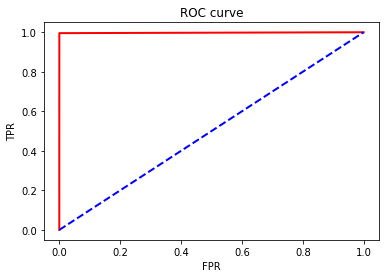

In [57]:
fpr, tpr,_= roc_curve(y_test, ypred_test)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Explainer using SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X)

# Trying with XGBOOST

In [58]:
from xgboost import XGBClassifier

In [61]:

roc_auc_scoreDict1 = {}
max_depth = [1, 3, 5]
learning_rate= [0.5, 0.1, 0.01]
subsample = [0.1, 0.5, 1]
ind = 0
for d in max_depth:
#    print(t)
    roc_auc_scoreDict1[d] = {}
    for l in learning_rate:
        roc_auc_scoreDict1[d][l] = {}
        for s in subsample:
            print("%d, %f, %f " % (d, l, s))
            clf2 = XGBClassifier(max_depth= d, learning_rate=l, subsample=s,early_stopping_rounds=100,n_jobs=-1)
            clf2.fit(X_train,y_train)
            y_pred = clf2.predict_proba(X_val[:])[:, 1]
            
            roc_auc_scoreDict1[d][l][s] = roc_auc_score(y_val, y_pred)
print(roc_auc_scoreDict1)
    

1, 0.500000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.500000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.500000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.100000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.100000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.100000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.010000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.010000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, 0.010000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.500000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.500000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.500000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.100000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.100000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.100000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.010000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.010000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3, 0.010000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.500000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.500000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.500000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.100000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.100000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.100000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.010000, 0.100000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.010000, 0.500000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5, 0.010000, 1.000000 


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{1: {0.5: {0.1: 0.8598237729153579, 0.5: 0.862241411945794, 1: 0.8622170167976935}, 0.1: {0.1: 0.8589170389404377, 0.5: 0.8572580716308142, 1: 0.8567395207722697}, 0.01: {0.1: 0.8340164760569445, 0.5: 0.8273977915634346, 1: 0.8238223450728499}}, 3: {0.5: {0.1: 0.8566384808364842, 0.5: 0.8777579931885824, 1: 0.8822826876288183}, 0.1: {0.1: 0.8679530147620672, 0.5: 0.8700555529883862, 1: 0.8695886712833558}, 0.01: {0.1: 0.8498910905000119, 0.5: 0.8435369396966497, 1: 0.8361071747247337}}, 5: {0.5: {0.1: 0.843350718586653, 0.5: 0.9100839894981878, 1: 0.9131168052715161}, 0.1: {0.1: 0.8760684398616521, 0.5: 0.883097905175461, 1: 0.882640343660483}, 0.01: {0.1: 0.8616475599627526, 0.5: 0.8588860345016995, 1: 0.8550290846799584}}}


In [62]:
from pprint import pprint
pprint(roc_auc_scoreDict1)

{1: {0.01: {0.1: 0.8340164760569445,
            0.5: 0.8273977915634346,
            1: 0.8238223450728499},
     0.1: {0.1: 0.8589170389404377,
           0.5: 0.8572580716308142,
           1: 0.8567395207722697},
     0.5: {0.1: 0.8598237729153579,
           0.5: 0.862241411945794,
           1: 0.8622170167976935}},
 3: {0.01: {0.1: 0.8498910905000119,
            0.5: 0.8435369396966497,
            1: 0.8361071747247337},
     0.1: {0.1: 0.8679530147620672,
           0.5: 0.8700555529883862,
           1: 0.8695886712833558},
     0.5: {0.1: 0.8566384808364842,
           0.5: 0.8777579931885824,
           1: 0.8822826876288183}},
 5: {0.01: {0.1: 0.8616475599627526,
            0.5: 0.8588860345016995,
            1: 0.8550290846799584},
     0.1: {0.1: 0.8760684398616521,
           0.5: 0.883097905175461,
           1: 0.882640343660483},
     0.5: {0.1: 0.843350718586653,
           0.5: 0.9100839894981878,
           1: 0.9131168052715161}}}


In [ ]:
reform = {(level1_key, level2_key, level3_key): values
            for level1_key, level2_dict in roc_auc_scoreDict1.items()
             for level2_key, level3_dict in level2_dict.items()
              for level3_key, values      in level3_dict.items()}
reform